# Name: Soh Jian Min
# Admin Number: P2238856
# Class: EL/EP0302/FT
# Title: Assessing the Influence of Temperature and Rainfall on Air Quality
---
## Questions

1. What is the distribution of daily PSI values throughout the study period?

2. What is the proportion of days categorized into different air quality levels based on the PSI values?

3. How have wet bulb temperatures and monthly total rainfall fluctuated over the study period?

4. What are the yearly variations in air quality indicators, specifically the daily PSI and annual PM2.5 levels?

5. Do variations in wet bulb temperature and monthly rainfall correlate with changes in air quality, particularly the daily PSI?

6. How do environmental factors specifically wet bulb temperature correlate with particulate matter (PM2.5) levels, and how does this relationship vary across different years?

7. Do heavy rainfall events lead to improvements in air quality due to pollutant washout, as observed in yearly data?

8. How do air quality indices, particularly PSI, respond to rainfall and temperature change, is there any trend over the months throughout the years?


## Data Source
1. https://beta.data.gov.sg/datasets/d_b16d06b83473fdfcc92ed9d37b66ba58/view
2. https://beta.data.gov.sg/datasets/d_b4cf557f8750260d229c49fd768e11ed/view
3. https://beta.data.gov.sg/datasets/d_397fe8de643aea9927bdee32e49307ff/view
4. https://beta.data.gov.sg/datasets/d_f222c70a7c00c5a5a9d4ec432d67f6e8/view

## Load data from CSV files

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Importing Wet Bulb Temperature Hourly data
wet_bulb_temperature = np.genfromtxt("WetBulbTemperatureHourly.csv", dtype=[('wbt_date', 'U10'), ('wbt_time', 'i2'), ('wet_bulb_temperature', 'f4')], delimiter=",", names=True, encoding='utf-8')

# Importing Air Pollutant Particulate Matter PM2.5 data
air_pollutant_particulate_matter = np.genfromtxt("AirPollutantParticulateMatterPM2.5.csv", dtype=[('year', 'i2'), ('pm25_mean', 'i2')], delimiter=",", names=True, encoding='utf-8')

# Importing Historical 24-hour PSI data
historical_psi = np.genfromtxt("Historical24hrPSI.csv", dtype=[('24hr_psi', 'U20'), ('north', 'i2'), ('south', 'i2'), ('east', 'i2'), ('west', 'i2'), ('central', 'i2')], delimiter=",", names=True, encoding='utf-8')

# Importing Rainfall Monthly Total data
rainfall_monthly_number_of_rain_days = np.genfromtxt("RainfallMonthlyNumberofRainDays.csv", dtype=[('month', 'U10'), ('no_of_rainy_days', 'i2')], delimiter=",", names=True, encoding='utf-8')

# Cleaning and filtering Datasets

In [2]:
from datetime import datetime

# Function to filter to show only 2014-2022 data
def filter_data_by_year(data, date_column, start_year=2014, end_year=2022, format='%Y-%m-%d'):
    return data[np.array([start_year <= datetime.strptime(date, format ).year <= end_year for date in data[date_column]])]

# Function to convert date into the appropariate format
def convert_date_format(date_str, original_format, new_format='%Y-%m-%d', error_message="Failed to parse datetime"):
    if date_str == '2016-04-04 010:00:00': 
        return '2016-04-04'
    try:
        return datetime.strptime(date_str, original_format).strftime(new_format)
    except ValueError:
        print(f"{error_message}: {date_str}")
        return None
    
# Check if dates are in the right format and filter out any incorrect formats
def validate_dates(data, date_column, format):
    valid_dates = []
    for date in data[date_column]:
        try:
            datetime.strptime(date, format)
            valid_dates.append(True)
        except ValueError:
            valid_dates.append(False)
    return data[np.array(valid_dates)]

# Function to get the average of the data if they have the same date
def aggregate_data_by_date(data, date_column, aggregation_columns):
    # Getting the unique dates
    unique_dates = np.unique(data[date_column][data[date_column] != None])
    # Empty numpy array with the length based on unique dates and with the columns that is passed into functions
    aggregated_data = np.zeros(len(unique_dates), dtype=[(date_column, 'U10')] + [(col, 'f4') for col in aggregation_columns])
    # Seed the date column with the unique dates
    aggregated_data[date_column] = unique_dates
    # Loop through unique_dates to get the mask of the rows that have the same dates and calculate the average for the columns that require aggregation
    for date in unique_dates:
        # get the indexs of the rows where its date is the same as current looping date
        date_mask = data[date_column] == date
        for col in aggregation_columns:
            if np.any(date_mask):
                # replacing the data in the specified looping column where row is the current looping date with the mean of the data in the original data for the corresponding column where its date is the same as current looping date
                aggregated_data[col][aggregated_data[date_column] == date] = round(np.mean(data[col][date_mask]), 2)
    return aggregated_data

# validate date format
wet_bulb_temperature = validate_dates(wet_bulb_temperature, 'wbt_date', '%Y-%m-%d')
rainfall_monthly_number_of_rain_days = validate_dates(rainfall_monthly_number_of_rain_days, 'month', '%Y-%m')

# Filtering data to only show 2014-2022 data 
wet_bulb_temperature = filter_data_by_year(wet_bulb_temperature, 'wbt_date')
rainfall_monthly_number_of_rain_days = filter_data_by_year(rainfall_monthly_number_of_rain_days, 'month', format='%Y-%m')


# Convert the dates to the standard format 'yyyy-mm' and put it back into historical_psi['24hr_psi']
historical_psi['24hr_psi'] = np.array([convert_date_format(dt, '%d/%m/%Y %H:%M') for dt in historical_psi['24hr_psi']])
# Filter out any entries where date conversion failed
historical_psi = historical_psi[historical_psi['24hr_psi'] != None]

# Validate date formats
historical_psi = validate_dates(historical_psi, '24hr_psi', '%Y-%m-%d')

historical_psi = filter_data_by_year(historical_psi, '24hr_psi')

# Aggregating data by unique dates
wet_bulb_temperature = aggregate_data_by_date(wet_bulb_temperature, 'wbt_date', ['wet_bulb_temperature'])
historical_psi = aggregate_data_by_date(historical_psi, '24hr_psi', ['north', 'south', 'east', 'west', 'central'])

# Filtering Air Pollutant Particulate Matter PM2.5 data to only show 2014-2022 data
air_pollutant_particulate_matter = air_pollutant_particulate_matter[(air_pollutant_particulate_matter['year'] >= 2014) & (air_pollutant_particulate_matter['year'] <= 2022)]



# Nature of the Datasets

### 1. Wet Bulb Temperature - Hourly Data
This dataset initially contained hourly temperature data which was too much for trend analysis which only requires daily data. To simplify and focus on more significant temperature trends over time, the data was cleaned and aggregated to daily averages. This transformation helps in identifying broader climatic patterns and planning for potential extreme weather events.

### 2. Air Pollutant - Particulate Matter PM2.5
The PM2.5 dataset offers annual snapshots of particulate matter concentrations, crucial for studying long-term air quality trends. Given the yearly aggregation, this data is good in identifying years with significantly poor air quality and do temperature or rainfall affect the air quality.

### 3. Historical 24-hr PSI
The Historical 24-hr PSI dataset captures monthly air quality indices across five geographical regions. The original data was voluminous and less impactful for identifying longer-term pollution trends, hence it was cleaned to provide a daily aggregated view instead of hourly data.

### 4. Rainfall - Monthly Total Rainfall
Monthly rain day counts from this dataset are utilized to understand rainfall patterns better over months and years. Which could be used to analyse whether enviromental conditions affects air quality



# Nature and statistics of wet_bulb_temperature


In [76]:
# Total rows in the wet_bulb_temperature dataset
num_rows = len(wet_bulb_temperature)
print(f"Number of rows in the dataset: {num_rows}")

# Highest temperature in the dataset\
max_temp = wet_bulb_temperature[np.argmax(wet_bulb_temperature['wet_bulb_temperature'])]
print(f"The highest temperature was {max_temp['wet_bulb_temperature']:.2f}°C in {max_temp['wbt_date']}.")

# Mean of each month's temperature across the years (2014-2022)
monthly_avg_temperatures = np.zeros(12)
for i in range(1, 13):
    # Create a mask for the current month using datetime parsing
    month_mask_temp = np.array([datetime.strptime(date, '%Y-%m-%d').month == i for date in wet_bulb_temperature['wbt_date']])
    # Get the temperatures for the current month with the mask
    month_temps = wet_bulb_temperature['wet_bulb_temperature'][month_mask_temp]
    # Calculate the mean temperature for the current month
    if month_temps.size > 0:
        monthly_avg_temperatures[i-1] = np.mean(month_temps)
    else:
        monthly_avg_temperatures[i-1] = np.nan  

full_month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# Display the monthly averages
print("Average temperatures for each month across all years:")
for i in range(12):
    print(f"{full_month_names[i]}: {monthly_avg_temperatures[i]:.2f}°C")

# Find the month with the highest and lowest average temperature
highest_avg_month = np.argmax(monthly_avg_temperatures)
lowest_avg_month = np.argmin(monthly_avg_temperatures)
print(f"{full_month_names[highest_avg_month]} has the highest average temperature of {monthly_avg_temperatures[highest_avg_month]:.2f}°C across all years.")
print(f"{full_month_names[lowest_avg_month]} has the lowest average temperature of {monthly_avg_temperatures[lowest_avg_month]:.2f}°C across all years.")
print()

# Average temperature for each year from 2014 to 2022
yearly_avg_temperatures = {}
for year in range(2014, 2023):  # Loop through the years 2014 to 2022
    # Create a mask for the current year using datetime parsing
    year_mask = np.array([datetime.strptime(date, '%Y-%m-%d').year == year for date in wet_bulb_temperature['wbt_date']])
    # Get the temperatures for the current year with the mask
    year_temps = wet_bulb_temperature['wet_bulb_temperature'][year_mask]
    # Calculate the mean temperature for the current year
    if year_temps.size > 0:
        yearly_avg_temperatures[year] = np.mean(year_temps)
    else:
        yearly_avg_temperatures[year] = np.nan  # Handle possible missing data

# Display the yearly averages
print("Average temperatures for each year:")
for year, temp in yearly_avg_temperatures.items():
    print(f"Year {year}: {temp:.2f}°C")

# Find the year with the highest and lowest average temperature
highest_avg_year = max(yearly_avg_temperatures, key=yearly_avg_temperatures.get)
lowest_avg_year = min(yearly_avg_temperatures, key=yearly_avg_temperatures.get)
print(f"Year {highest_avg_year} had the highest average temperature: {yearly_avg_temperatures[highest_avg_year]:.2f}°C.")
print(f"Year {lowest_avg_year} had the lowest average temperature: {yearly_avg_temperatures[lowest_avg_year]:.2f}°C.")

Number of rows in the dataset: 3287
The highest temperature was 27.73°C in 2019-05-07.
Average temperatures for each month across all years:
January: 24.37°C
February: 24.29°C
March: 24.94°C
April: 25.48°C
May: 25.96°C
June: 25.54°C
July: 25.42°C
August: 25.15°C
September: 25.00°C
October: 25.05°C
November: 24.95°C
December: 24.67°C
May has the highest average temperature of 25.96°C across all years.
February has the lowest average temperature of 24.29°C across all years.

Average temperatures for each year:
Year 2014: 24.96°C
Year 2015: 25.04°C
Year 2016: 25.05°C
Year 2017: 25.34°C
Year 2018: 25.08°C
Year 2019: 25.17°C
Year 2020: 25.05°C
Year 2021: 24.98°C
Year 2022: 24.98°C
Year 2017 had the highest average temperature: 25.34°C.
Year 2014 had the lowest average temperature: 24.96°C.


# Nature and statistics of air_pollutant_particulate_matter

In [4]:
# Total number of entries in the dataset
num_entries = len(air_pollutant_particulate_matter)
print(f"Number of entries in the dataset: {num_entries}")

# Calculate the average PM2.5 levels over all years
average_pm2_5 = np.mean(air_pollutant_particulate_matter['pm25_mean'])
print(f"Average PM2.5 level from year 2014-2022: {average_pm2_5:.2f} µg/m³")

# Find the year with the highest and lowest PM2.5 levels
highest_pm2_5_year = air_pollutant_particulate_matter[np.argmax(air_pollutant_particulate_matter['pm25_mean'])]
lowest_pm2_5_year = air_pollutant_particulate_matter[np.argmin(air_pollutant_particulate_matter['pm25_mean'])]

print(f"Year {highest_pm2_5_year['year']} had the highest PM2.5 level: {highest_pm2_5_year['pm25_mean']} µg/m³")
print(f"Year {lowest_pm2_5_year['year']} had the lowest PM2.5 level: {lowest_pm2_5_year['pm25_mean']} µg/m³")

Number of entries in the dataset: 9
Average PM2.5 level from year 2014-2022: 15.11 µg/m³
Year 2015 had the highest PM2.5 level: 24 µg/m³
Year 2020 had the lowest PM2.5 level: 11 µg/m³


# Nature and statistics of historical_psi

In [81]:
# Total number of entries in the historical_psi dataset
num_entries = len(historical_psi)
print(f"Number of entries in the dataset: {num_entries}")

# Find the month with the highest average PSI for North
highest_psi = np.max(historical_psi['north'])
highest_psi_month = historical_psi['24hr_psi'][np.argmax(historical_psi['north'])]
print(f"Highest PSI was {highest_psi:.2f} in {highest_psi_month} for the North region.")

# Find the month with the lowest average PSI for South
lowest_psi = np.min(historical_psi['south'])
lowest_psi_month = historical_psi['24hr_psi'][np.argmin(historical_psi['south'])]
print(f"Lowest PSI was {lowest_psi:.2f} in {lowest_psi_month} for the South region.")

# Find the month with the highest average PSI for East
highest_psi = np.max(historical_psi['east'])
highest_psi_month = historical_psi['24hr_psi'][np.argmax(historical_psi['east'])]
print(f"Highest PSI was {highest_psi:.2f} in {highest_psi_month} for the East region.")

# Find the month with the lowest average PSI for West
lowest_psi = np.min(historical_psi['west'])
lowest_psi_month = historical_psi['24hr_psi'][np.argmin(historical_psi['west'])]
print(f"Lowest PSI was {lowest_psi:.2f} in {lowest_psi_month} for the West region.")

# Find the month with the highest average PSI for Central
highest_psi = np.max(historical_psi['central'])
highest_psi_month = historical_psi['24hr_psi'][np.argmax(historical_psi['central'])]
print(f"Highest PSI was {highest_psi:.2f} in {highest_psi_month} for the Central region.")

# Average PSI per month across all years
monthly_avg_region_psi = {region: {month: None for month in full_month_names} for region in ['north', 'south', 'east', 'west', 'central']}
# Calculate average PSI for each month and region
for i, month in enumerate(full_month_names, start=1):
    # Create a mask for the current month using datetime parsing
    month_mask_psi = np.array([datetime.strptime(date, '%Y-%m-%d').month == i for date in historical_psi['24hr_psi']])
    for region in monthly_avg_region_psi:
        month_psi = historical_psi[region][month_mask_psi]
        if month_psi.size > 0:
            monthly_avg_region_psi[region][month] = np.mean(month_psi)
        else:
            monthly_avg_region_psi[region][month] = np.nan

# Display the monthly averages for each region
for region, average_data in monthly_avg_region_psi.items():
    print()
    print(f"Average PSI for each month across all years for {region.capitalize()}:")
    for month, avg_psi in average_data.items():
        if avg_psi is not None:
            print(f"{month}: {avg_psi:.2f}")
        else:
            print(f"{month}: No data available")
    # End of loop for each month in region
    highest_avg_month = max(average_data, key=average_data.get)
    highest_avg_psi = average_data[highest_avg_month]
    if highest_avg_psi is not None:
        print(f"{highest_avg_month} has the highest average PSI of {highest_avg_psi:.2f} for {region.capitalize()} across all years.")
    else:
        print(f"No valid data to determine the highest average PSI for {region.capitalize()}.")
    lowest_avg_month = min(average_data, key=average_data.get)
    lowest_avg_psi = average_data[lowest_avg_month]
    if lowest_avg_psi is not None:
        print(f"{lowest_avg_month} has the lowest average PSI of {lowest_avg_psi:.2f} for {region.capitalize()} across all years.")
    else:
        print(f"No valid data to determine the lowest average PSI for {region.capitalize()}.")

Number of entries in the dataset: 3197
Highest PSI was 263.33 in 2015-09-25 for the North region.
Lowest PSI was 16.62 in 2018-01-12 for the South region.
Highest PSI was 252.67 in 2015-09-25 for the East region.
Lowest PSI was 15.71 in 2022-01-03 for the West region.
Highest PSI was 234.38 in 2015-09-25 for the Central region.

Average PSI for each month across all years for North:
January: 43.16
February: 45.66
March: 50.37
April: 55.07
May: 51.81
June: 50.07
July: 51.36
August: 53.57
September: 63.80
October: 60.47
November: 48.27
December: 41.83
September has the highest average PSI of 63.80 for North across all years.
December has the lowest average PSI of 41.83 for North across all years.

Average PSI for each month across all years for South:
January: 44.00
February: 48.07
March: 51.84
April: 53.81
May: 47.80
June: 46.17
July: 48.44
August: 51.29
September: 61.34
October: 60.79
November: 48.56
December: 43.69
September has the highest average PSI of 61.34 for South across all ye

# Nature and statistics of rainfall_monthly_number_of_rain_days

In [6]:
# Total number of entries in the rainfall_monthly_number_of_rain_days dataset
num_entries = len(rainfall_monthly_number_of_rain_days)
print(f"Number of entries in the dataset: {num_entries}")

# Calculate the average raindats over all years
avg_number_of_rain_days = np.mean(rainfall_monthly_number_of_rain_days['no_of_rainy_days'])
print(f"Average Number of raindays from year 2014-2022: {avg_number_of_rain_days:.2f}")

# Find the year with the highest and lowest number of rain days
highest_number_of_rain_days = rainfall_monthly_number_of_rain_days[np.argmax(rainfall_monthly_number_of_rain_days['no_of_rainy_days'])]
lowest_number_of_rain_days = rainfall_monthly_number_of_rain_days[np.argmin(rainfall_monthly_number_of_rain_days['no_of_rainy_days'])]

print(f"{highest_number_of_rain_days['month']} had the highest number of rain days: {highest_number_of_rain_days['no_of_rainy_days']}")
print(f"{lowest_number_of_rain_days['month']} had the lowest number of rain days: {lowest_number_of_rain_days['no_of_rainy_days']}")
print()

# Mean of each month's rain days across the years (2014 - 2022)
monthly_avg_no_of_rain_days = np.zeros(12)
for i in range(1, 13):
    # Create a mask for the current month
    month_mask_rainfall = np.array([datetime.strptime(date, '%Y-%m').month == i for date in rainfall_monthly_number_of_rain_days['month']])
    month_no_of_rain_days = rainfall_monthly_number_of_rain_days['no_of_rainy_days'][month_mask_rainfall]
    if month_no_of_rain_days.size > 0:
        monthly_avg_no_of_rain_days[i-1] = np.mean(month_no_of_rain_days)
    else:
        monthly_avg_no_of_rain_days[i-1] = np.nan  # Handle possible missing data

# Display the monthly averages
print("Average no of rainy days for each month across all 2014-2022:")
for i in range(12):
    print(f"{full_month_names[i]}: {monthly_avg_no_of_rain_days[i]:.2f}")

Number of entries in the dataset: 108
Average Number of raindays from year 2014-2022: 14.24
2018-11 had the highest number of rain days: 27
2014-02 had the lowest number of rain days: 1

Average no of rainy days for each month across all 2014-2022:
January: 12.56
February: 7.56
March: 9.67
April: 14.67
May: 14.44
June: 15.00
July: 13.89
August: 14.67
September: 12.67
October: 15.89
November: 21.11
December: 18.78


# Question 1: What is the distribution of daily PSI values throughout the study period?

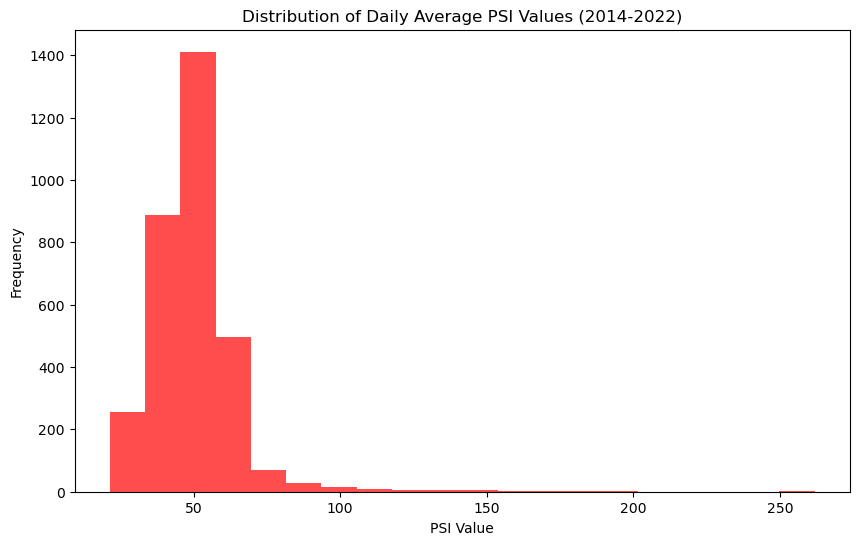

In [7]:
# Calculate daily average PSI across all regions
daily_avg_psi = np.mean([historical_psi['north'], historical_psi['south'], historical_psi['east'], historical_psi['west'], historical_psi['central']], axis=0)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(daily_avg_psi, bins=20, color='red', alpha=0.7)
plt.title('Distribution of Daily Average PSI Values (2014-2022)')
plt.xlabel('PSI Value')
plt.ylabel('Frequency')
plt.show()

### Analyse Distribution of Daily Average PSI Value
1. The majority of daily average PSI values during the 2014-2022 period are clustered around 50. The histogram shows a very high frequency (peak) at the PSI value of around 50, indicating that most days had relatively low PSI readings in this range.

2. However, there is a smaller but notable number of days with higher PSI values as well. The distribution has a long tail extending towards higher PSI levels, with some values reaching above 100 and even a few instances above 250.

3. This distribution pattern suggests that while the air quality was generally good with low PSI values on most days, there were occasional periods or events that led to elevated PSI levels, indicating poorer air quality conditions.

Through this statistic I will continue investigating about the potential influence of weather factors like temperature and rainfall on these higher PSI instances.

# Question 2: What is the proportion of days categorized into different air quality levels based on the PSI values?

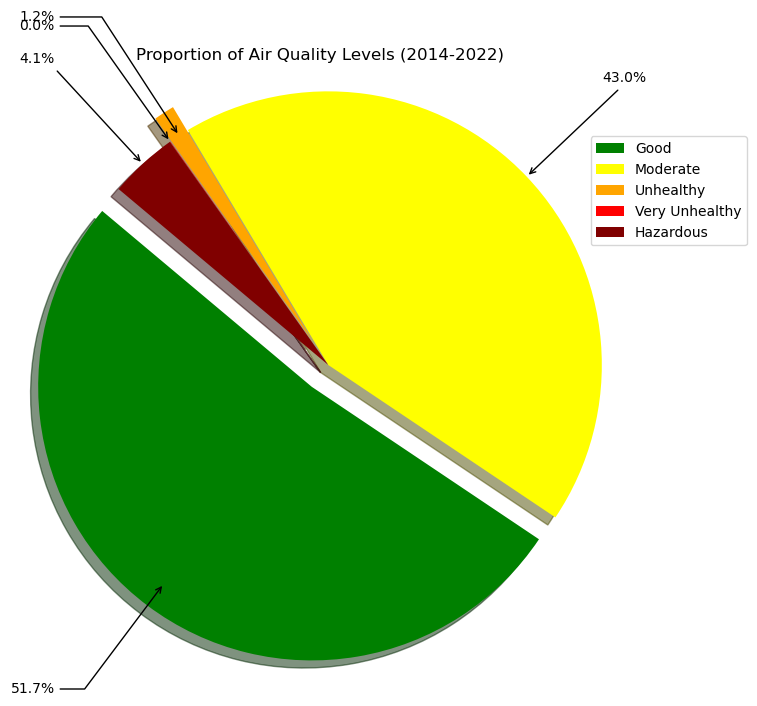

In [68]:
# Count the number of occurrences of each category
categories = {'Good': 0, 'Moderate': 0, 'Unhealthy': 0, 'Very Unhealthy': 0, 'Hazardous': 0}
for avg_psi in daily_avg_psi:
    if avg_psi <= 50:
        categories['Good'] += 1
    elif 51 <= avg_psi <= 100:
        categories['Moderate'] += 1
    elif 101 <= avg_psi <= 200:
        categories['Unhealthy'] += 1
    elif 201 <= avg_psi <= 300:
        categories['Very Unhealthy'] += 1
    else:
        categories['Hazardous'] += 1

# Filter out categories with 0 counts
filtered_categories = {k: v for k, v in categories.items() if v > 0}

# Plot the pie chart
labels = filtered_categories.keys()
sizes = filtered_categories.values()
colors = ['green', 'yellow', 'orange', 'red', 'maroon']
explode = (0.1, 0, 0.1, 0, 0)
plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140,
                                   pctdistance=0.85)

# Add legend
plt.legend(patches, labels, loc='upper right', bbox_to_anchor=(1.2, 0.9))

# Annotate with arrows for percentages
for i, (autotext, patch) in enumerate(zip(autotexts, patches)):
    angle = (patch.theta2 - patch.theta1) / 2. + patch.theta1
    x = patch.r * np.cos(np.deg2rad(angle))
    y = patch.r * np.sin(np.deg2rad(angle))
    horizontalalignment = {-1: 'right', 1: 'left'}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(angle)
    plt.annotate(autotext.get_text(), xy=(x, y), xytext=(np.sign(x), 1.5*y),
                 horizontalalignment=horizontalalignment, arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle))
    autotext.set_text('')  # Remove original text to avoid duplication

plt.title('Proportion of Air Quality Levels (2014-2022)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


**Analyse proportion of air quality level (2014-2022)**
1. The majority of days (51.7%) experienced "Good" air quality levels, as indicated by the PSI values falling within the healthy range.

2. A significant portion (43.0%) of days had "Moderate" air quality, suggesting that while not ideal, the air quality was not severely degraded.

3. However, it is noteworthy that a non-negligible percentage of days (4.1%) were classified as "Unhealthy," and an additional 1.2% were categorized as "Very Unhealthy" in terms of air quality levels.

4. While these percentages for "Unhealthy" and "Very Unhealthy" levels may seem small, they represent instances where air pollution levels could have potentially harmful effects on public health and the environment.

5. Given the occurrence of days with elevated PSI values, it is crucial to investigate the role of environmental factors, such as temperature and rainfall patterns, in influencing air quality conditions.

Through this, I will continue examining the correlations between environment condition and the instances of unhealthy or hazardous air quality levels, valuable insights could be gained into the underlying drivers contributing to air pollution episodes. If there is relationship between weather conditions and air quality degradation found , we could predict and inform the development of strategies and policies to mitigate or manage air pollution events more effectively, ultimately safeguarding public health and environmental well-being.

# Question 3: How have wet bulb temperatures and monthly total rainfall fluctuated over the study period?

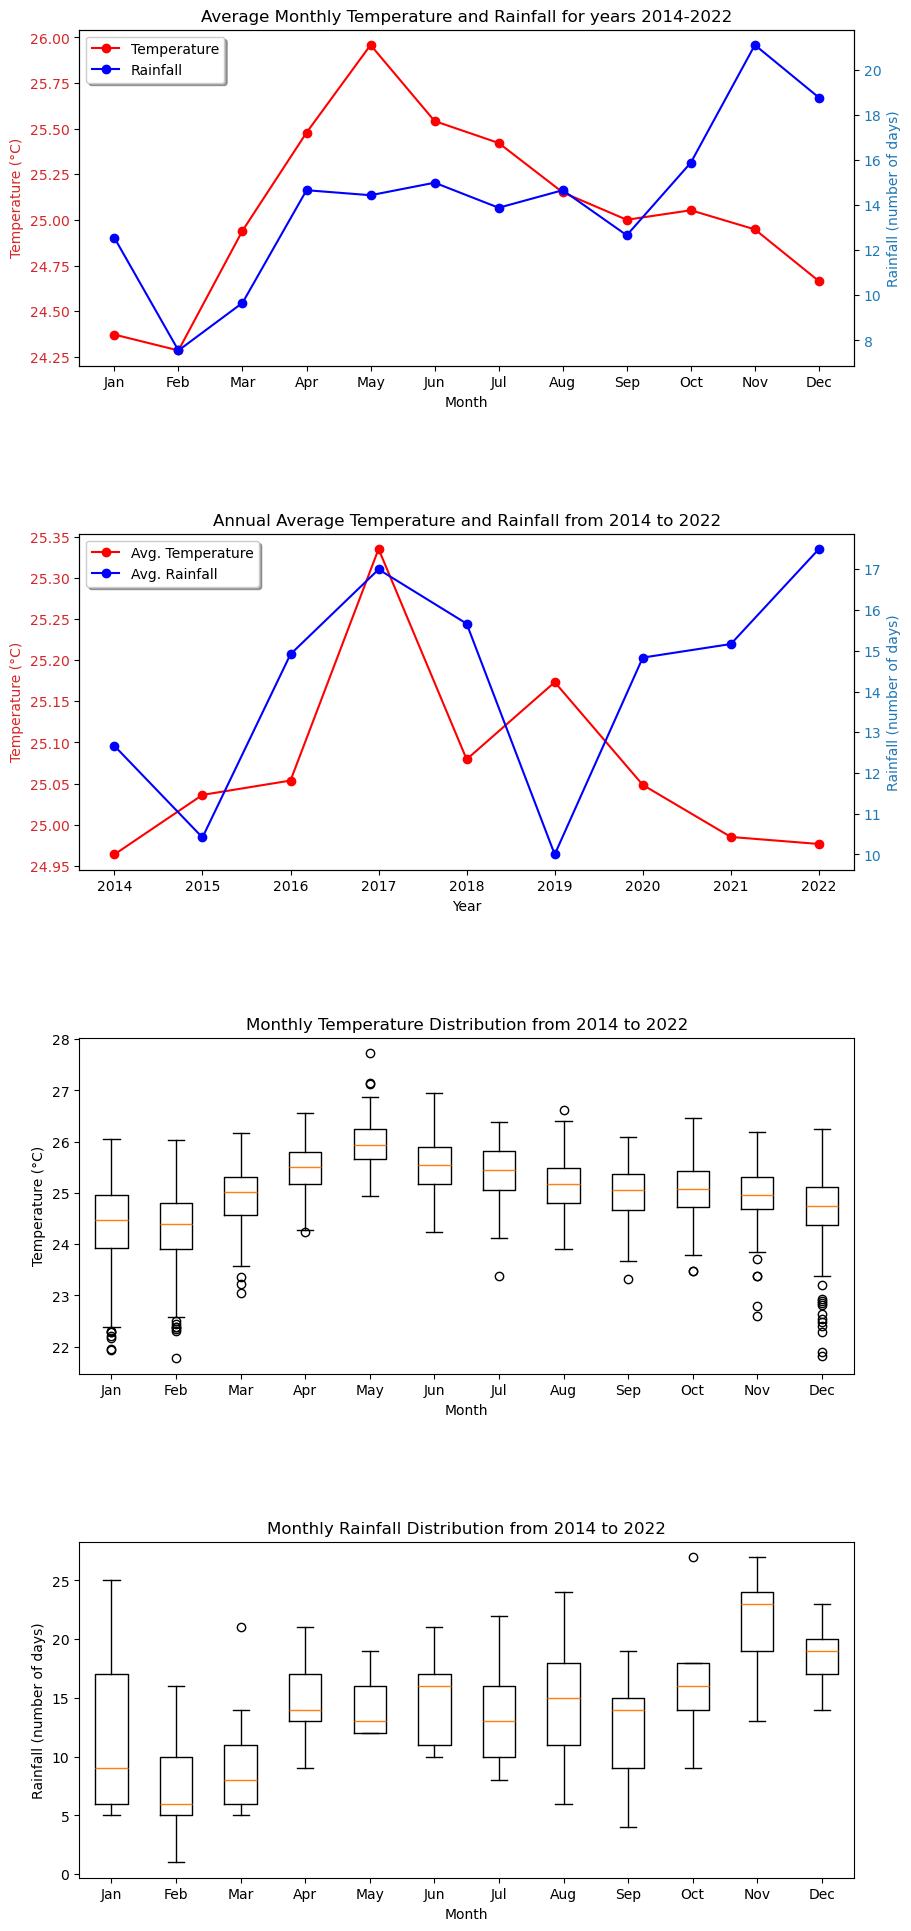

In [9]:
monthly_temperatures = {month: [] for month in range(1, 13)}
monthly_rainfall = {month: [] for month in range(1, 13)}
yearly_avg_rainfall = []

# Collect all temperatures and rainfall per month across all years
for record in wet_bulb_temperature:
    month = datetime.strptime(record['wbt_date'], '%Y-%m-%d').month
    monthly_temperatures[month].append(record['wet_bulb_temperature'])

for record in rainfall_monthly_number_of_rain_days:
    month = datetime.strptime(record['month'], '%Y-%m').month
    monthly_rainfall[month].append(record['no_of_rainy_days'])

# Aggregate data for each year
years = range(2014, 2023)
for y in years:
    yearly_rain = [record['no_of_rainy_days'] for record in rainfall_monthly_number_of_rain_days if datetime.strptime(record['month'], '%Y-%m').year == y]
    yearly_avg_rainfall.append(np.mean(yearly_rain) if yearly_rain else np.nan)

# Convert lists to arrays for plotting
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot configuration
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 24), gridspec_kw={'hspace': 0.5})

# First plot: Line chart for average monthly temperatures and rainfall over the years
ax1, ax2, ax3, ax4 = axes
ax1.set_title('Average Monthly Temperature and Rainfall for years 2014-2022')
ax1.set_xlabel('Month')
ax1.set_ylabel('Temperature (°C)', color='tab:red')

line1, = ax1.plot(month_labels, monthly_avg_temperatures, 'ro-', label='Temperature')

ax1.tick_params(axis='y', labelcolor='tab:red')

ax1b = ax1.twinx()
ax1b.set_ylabel('Rainfall (number of days)', color='tab:blue')
line2, = ax1b.plot(month_labels, monthly_avg_no_of_rain_days, 'bo-', label='Rainfall')
ax1b.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend([line1, line2], ['Temperature', 'Rainfall'], loc='upper left', shadow=True)

# Second Plot for 2014-2022 Annual Averages
ax2.set_xlabel('Year')
ax2.set_ylabel('Temperature (°C)', color='tab:red')
line3, = ax2.plot(years, list(yearly_avg_temperatures.values()), 'ro-', label='Avg. Temperature')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax2b = ax2.twinx()
ax2b.set_ylabel('Rainfall (number of days)', color='tab:blue')
line4, = ax2b.plot(years, yearly_avg_rainfall, 'bo-', label='Avg. Rainfall')
ax2b.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title('Annual Average Temperature and Rainfall from 2014 to 2022')
ax2.legend([line3, line4], ['Avg. Temperature', 'Avg. Rainfall'], loc='upper left', shadow=True)

# Third plot: Box plot for temperatures
ax3.boxplot([monthly_temperatures[month] for month in range(1, 13)], labels=month_labels)
ax3.set_title('Monthly Temperature Distribution from 2014 to 2022')
ax3.set_ylabel('Temperature (°C)')
ax3.set_xlabel('Month')

# Fourth Box plot for rainfall
ax4.boxplot([monthly_rainfall[month] for month in range(1, 13)], labels=month_labels)
ax4.set_title('Monthly Rainfall Distribution from 2014 to 2022')
ax4.set_ylabel('Rainfall (number of days)')
ax4.set_xlabel('Month')

plt.show()



### Analyse for Average Monthly Temperature and Rainfall for years 2014-2022
1. **Rainfall Analysis:** Rainfall shows a distinct pattern with two significant peaks, one in November and another in December. These peaks suggest periods of high precipitation which could correspond to seasonal weather patterns, more rainfall count at the near end of the months, which starts increasing from september. The lowest rainfall occurs in February and March, indicating drier conditions during these months.

2. **Temperature Analysis:** Temperatures are generally lowest in February, with a noticeable increase leading up to May, where they peak. This peak represents the warmest month on average for year 2014-2022. After May, temperatures generally decrease all the way till december.

3. **Relationship Rainfall and Temperature Analysis:** An inverse relationship is observable in several months, most notably from May, November and December, where an increase in temperature corresponds with a decrease in rainfall. This inverse relationship could suggest that higher temperatures might be drying out the atmosphere, reducing precipitation during warmer months, and conversely, cooler months could be more conducive to rainfall.

### Analyse for Annual Average Temperature and rainfall from 2014-2022
1. **Rainfall Analysis:** The average number of rainy days varies significantly across the years. The average number of rainy days is highest in year 2022. The count of rain days is the lowest in year 2019 and a start increase till 2022.

2. **Temperature Analysis:** Over the period from 2014 to 2022, the average temperature shows minor changes over the years. The temperature is mainly stable but there is a notable rapidly increase in year 2017 where it reaches the highest temperature of around 25.34°C. Over the years from 2014-2022, the temperature starts decreasing.

3. **Relationship Rainfall and Temperature Analysis:** As observed in the graph for years 2014-2022, there seems to be a general inverse relationship between temperature and rainfall. In years where the average temperature is lower, the rainfall count tends to be higher, which shows that more rainfall equals lower temperature. One signaficant example is from year 2019-2022, 2019 has a lower rainfall count with a higher temperature, the rainfall count consistenly increase from 2019-2022, the temperature also decrease over years 2019-2022.

### Analyse for Monthly Rainfall Distribution from 2014-2022
1. **Temperature range:** The box plot shows the range of temperatures for each month, with the box representing the interquartile range (IQR) and the whiskers indicating the minimum and maximum values.

2. **Seasonal variations:** There is a clear seasonal pattern, with higher temperatures observed during the middle months of years (Relatively high temperature from April-August) and lower temperatures during the months that is near the end or start of years (December, January, February).

3. **Outliers:** Some months have outliers, which are represented by individual dots above or below the whiskers. These outliers indicate unusually high or low temperatures for that particular month during the time period analyzed.

4. **Median temperatures:** The horizontal line within each box represents the median temperature for that month across the years analyzed.

5. **Variability:**  The box sizes provide an indication of the variability in temperatures for each month. Larger boxes suggest greater variability, while smaller boxes indicate less variability.

### Analyze for Monthly Temperature Distribution from 2014-2022
1. **General patterns:** There is a pattern in the temperature distribution across the months. Months like May, June, and July tend to have higher temperatures, while December and January generally have lower temperatures.

2. **Outliers:** The plot shows several outliers, represented by individual dots above or below the whiskers. These outliers represent exceptionally high or low temperature amounts for those particular months during the study period.

3. **Median temperature:** The horizontal line within each box represents the median monthly temperature for that particular month across the years analyzed. The median temperature peaks during the warmer months (May, June, July) and is lowest during the cooler months (December, January, February).

4. **Variability:** The size of the boxes and the length of the whiskers provide an indication of the variability in temperature for each month. Larger boxes and longer whiskers suggest higher variability, while smaller boxes and shorter whiskers indicate lower variability in temperature amounts for that month. The months with the largest variability appear to be May and June, potentially due to the transition between drier and wetter periods. The months with the smallest variability are typically during the relatively more stable periods (August, September, October).

### Analyze for Monthly Rainfall Distribution from 2014-2022 
1. **General patterns:** The rainfall distribution in Singapore shows patterns associated with the monsoon periods. Months like November and December tend to have higher rainfall amounts, as indicated by the larger boxes and whiskers. In contrast, months like February, March, and April generally have lower rainfall levels.

2. **Outliers:** The plot shows several outliers, represented by individual dots above or below the whiskers. These outliers represent exceptionally high or low rainfall amounts for those particular months during the study period.

3. **Median rainfall:** The horizontal line within each box represents the median monthly rainfall amount for that particular month across the years analyzed. There is a notable peak in November and December, indicating higher rainfall during these months, while February has the lowest median rainfall, suggesting it is the driest month.

4. **Variability:** The size of the boxes and the length of the whiskers provide an indication of the variability in rainfall for each month. Larger boxes and longer whiskers suggest higher variability, while smaller boxes and shorter whiskers indicate lower variability in rainfall amounts for that month. January shows the largest and longest whiskers, likely due to the transition between wetter and drier periods. May has the smallest box and whiskers, indicating it is a more stable month with less variability in rainfall.

### Summary of Findings on the analysis of the 4 graphs

1. Rainfall peaks in November and December, and is lowest in February and March, indicating wetter conditions during the Northeast Monsoon and drier conditions during the inter-monsoon period.
2. Temperatures are highest in May and lowest in February, showing a clear pattern where the hottest months precede the wetter monsoon season.
3. An inverse relationship between temperature and rainfall is evident, with higher temperatures generally corresponding to lower rainfall, particularly noticeable in the months of May, November, and December.

# Question 4: What are the yearly variations in air quality indicators, specifically the daily PSI and annual PM2.5 levels?

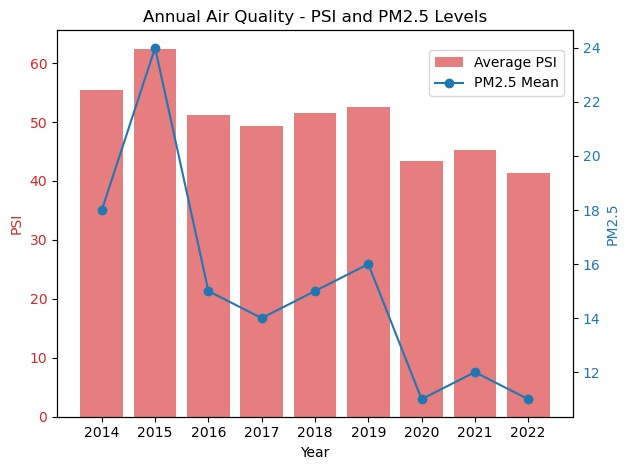

In [58]:
# Create a new column for year extraction from '24hr_psi' dates
years_in_24hr_psi = np.array([datetime.strptime(date, '%Y-%m-%d').year for date in historical_psi['24hr_psi']])

# Create an array to aggregate yearly average PSI
annual_avg_psi = []

# Calculate the average PSI for each year (2014-2022)
for year in years:
    # Mask to filter data for the current year
    year_mask = years_in_24hr_psi == year
    # Calculate the average PSI for this year using the mask
    if np.any(year_mask):
        annual_psi = np.mean(daily_avg_psi[year_mask])
    else:
        annual_psi = np.nan  # Handle years without data
    annual_avg_psi.append(annual_psi)

# Plotting
fig, ax1 = plt.subplots()

ax1.set_xlabel('Year')
ax1.set_ylabel('PSI', color='tab:red')
ax1.bar(years, annual_avg_psi, color='tab:red', alpha=0.6, label='Average PSI')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_title('Annual Air Quality - PSI and PM2.5 Levels')
ax1.set_xticks(years[::1])

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.set_ylabel('PM2.5', color='tab:blue')
ax2.plot(air_pollutant_particulate_matter['year'], air_pollutant_particulate_matter['pm25_mean'], color='tab:blue', marker='o', label='PM2.5 Mean')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()  # Otherwise the right y-label is slightly clipped
fig.legend(loc='upper right', bbox_to_anchor=(0.9,0.9))
plt.show()

### Analysis of Annual Air Quality - PSI and PM2.5 Levels from 2014-2022

1. **PSI (Pollutant Standards Index) Levels:**
   - Notable peaks in PSI values were observed in 2014 and 2015, indicating years of relatively poor air quality.
   - The highest PSI value was recorded in 2015, suggesting the most severe air pollution during that year.
   - After the peak in 2015, PSI values began to decrease, showing some improvement in air quality.

2. **PM2.5 (Particulate Matter 2.5) Levels:**
   - Annual mean PM2.5 levels generally mirrored the trend of PSI values, with some variations.
   - PM2.5 levels also peaked in 2015, indicating a period of high particulate matter pollution concurrent with the PSI peak.
   - After 2015, PM2.5 levels started to decrease, showing improvement.
   - A noticeable dip in PM2.5 levels occurred in 2020, possibly due to specific environmental or regulatory factors.

3. **Relationship Between PSI and PM2.5:**
   - The trends in PSI and PM2.5 levels show a positive correlation, suggesting that periods of high PSI values are often accompanied by elevated PM2.5 concentrations.
   - This correlation indicates that both metrics reflect similar air quality conditions, reinforcing their reliability as pollution indicators.

4. **Overall Air Quality Trend:**
   - The data indicates that 2015 was the worst year in terms of air quality, with the highest levels of both PSI and PM2.5.
   - Although there was an improvement in air quality after 2015, levels of both indicators remain relatively high, indicating a persistent air pollution issue over the years.

5. **Conclusion:**
   - Further investigation into the potential causes of high pollution levels, particularly in 2015, and ongoing air quality issues is warranted.
   - Implementing and enhancing mitigation strategies could help address observed air pollution problems.
   - Continuous monitoring and analysis are essential for predicting future air quality trends and effectively managing pollution levels.

# Question 5: Do variations in wet bulb temperature and monthly rainfall correlate with changes in air quality, particularly the daily PSI?


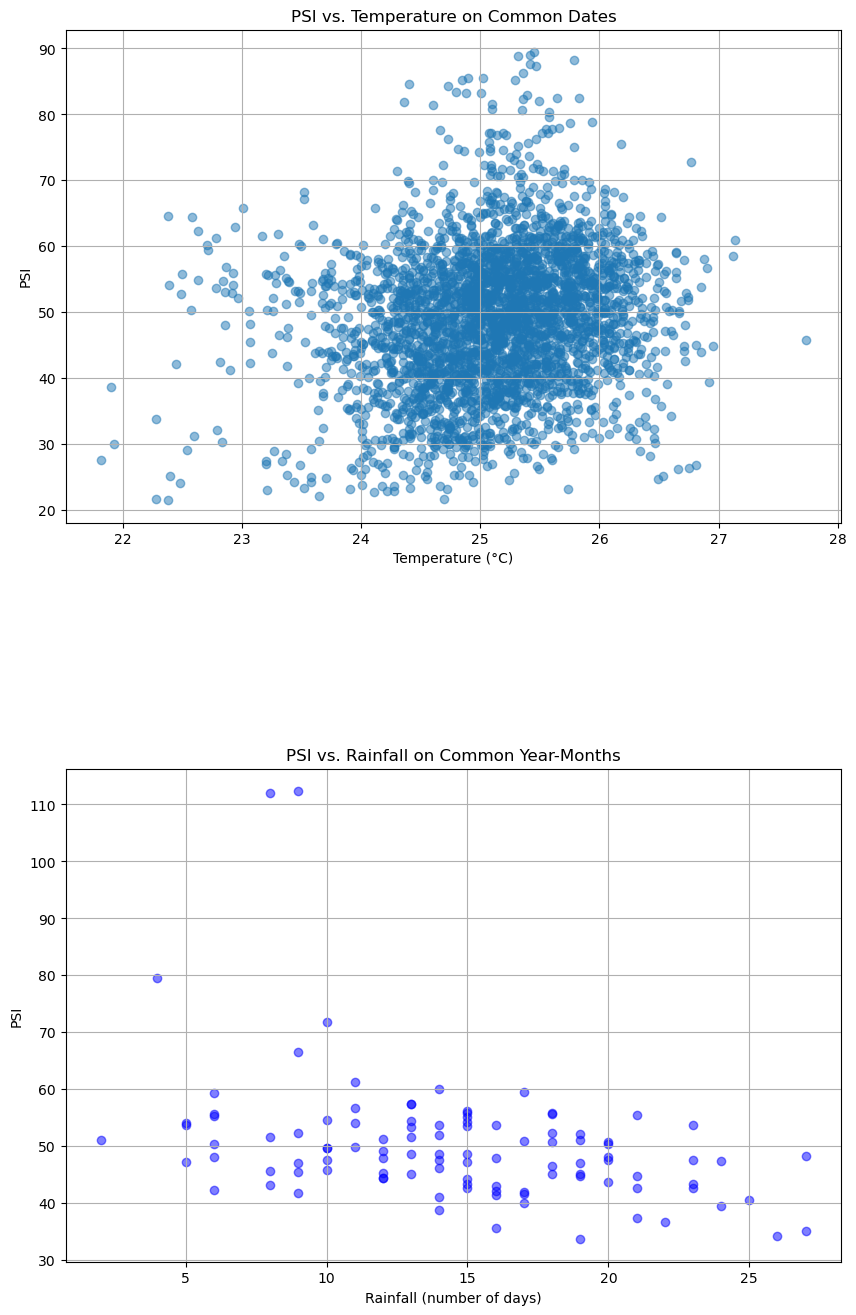

In [11]:
# Find the set of common dates in both historical_psi and wet_bulb_temperature (yyyy-mm-dd format)
common_dates = set(historical_psi['24hr_psi']) & set(wet_bulb_temperature['wbt_date'])

# Create lists to store common data points
psi_common = []
temp_common = []

# Iterate over common dates
for date in common_dates:
    # Get the index where the date matches in historical_psi
    psi_index = np.where(historical_psi['24hr_psi'] == date)[0][0]  # Access the first element since the date is unique
    
    # Get the index where the date matches in wet_bulb_temperature
    temp_index = np.where(wet_bulb_temperature['wbt_date'] == date)[0][0]  # Access the first element since the date is unique
    
    # Append daily average PSI and corresponding temperature to the lists
    psi_common.append(daily_avg_psi[psi_index])
    temp_common.append(wet_bulb_temperature['wet_bulb_temperature'][temp_index])

# Convert lists to numpy arrays
psi_common = np.array(psi_common)
temp_common = np.array(temp_common)

# Filter out PSI values above 90 (outliers)
mask = psi_common <= 90
filtered_psi = psi_common[mask]
filtered_temp = temp_common[mask]

# Getting the common months for psi and rainfall data
# Aggregate PSI data by month
monthly_psi = {}
for record in historical_psi:
    month_key = datetime.strptime(record['24hr_psi'], '%Y-%m-%d').strftime('%Y-%m')
    psi_avg = np.mean([record['north'], record['south'], record['east'], record['west'], record['central']])
    if month_key in monthly_psi:
        monthly_psi[month_key].append(psi_avg)
    else:
        monthly_psi[month_key] = [psi_avg]

# Calculate average PSI per year_month
year_month_psi_avg = {month: np.mean(values) for month, values in monthly_psi.items()}

# Use existing rainfall data, assuming it's already in the correct format
year_month_rainfall_avg = {record['month']: record['no_of_rainy_days'] for record in rainfall_monthly_number_of_rain_days}

# Find common months across all datasets
common_months = set(year_month_psi_avg.keys()) & set(year_month_rainfall_avg.keys())

# Filter out data for common months
common_month_psi = np.array([year_month_psi_avg[month] for month in common_months])
common_month_rainfall = np.array([year_month_rainfall_avg[month] for month in common_months])

# Plotting
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 16), gridspec_kw={'hspace': 0.5})

# Plot for PSI vs Temperature
ax1.scatter(filtered_temp, filtered_psi, alpha=0.5)
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('PSI')
ax1.set_title('PSI vs. Temperature on Common Dates')
ax1.grid(True)

# Plot for PSI vs Rainfall
ax2.scatter(common_month_rainfall, common_month_psi, color='blue', alpha=0.5)
ax2.set_xlabel('Rainfall (number of days)')
ax2.set_ylabel('PSI')
ax2.set_title('PSI vs. Rainfall on Common Year-Months')
ax2.grid(True)

plt.show()



### Analyse for PSI vs Temperature on Common Dates
1. **Filtering outliers:** Due to too many outliers above PSI 90, to have a clearer view for analyzing the PSI pattern, I filter all the data above PSI 90.

2. **Data distribution:** The data points are scattered across the temperature range, indicating that both low and high PSI values can occur at various temperature levels.

3. **Overall pattern:** Although the data points are widely scattered, there appears to be a general upward trend, suggesting that higher temperatures tend to be associated with higher PSI values (poorer air quality).

4. **High-density region:** The region with the highest density of data points lies approximately between temperatures of 24°C and 27°C, with PSI values ranging from around 20 to above 90. This suggests that moderate temperatures within this range are common, and air quality is have a wide range of PSI from good all the way to above unhealthy, which I have filtered out.

5. **Extreme values:** There are some outliers with very high PSI values (above 80) occurring between temperatures of 24°C and 26°C, indicating that extremely poor air quality usually occurs at this temperature range.

6. **Low PSI values:** Lower PSI values (better air quality) tend to occur more frequently at lower temperatures, with fewer data points in the lower temperature range exhibiting high PSI levels.

7. **Correlation strength:** There is a general upward trend; the scatter of data points indicates that the correlation between temperature and PSI is not extremely strong or linear. However, it is observed that temperature does play a significant role in affecting the value of PSI.

### Analyse for PSI vs Rainfall on Common Year-Months
1. **Data distribution:** Higher PSI (above 110) is observed during low rainfall counts of months (5-10). When there is a higher rainfall count, the PSI values are usually stably low (over 25 days of rainfall, PSI is observed to be below 50, which is at a good level).

2. **Overall pattern:** Although the data points are widely scattered, there appears to be a general trend where lower rainfall counts correspond to higher PSI values, and higher rainfall counts correspond to lower PSI values.

3. **Extreme values:** There are some outliers with very high PSI values (above 110) when the rainfall count is 5-10 in the month.

4. **Low PSI values:** Lower PSI values (better air quality) tend to occur more frequently when the rainfall count is higher. When the rainfall count is 20-25 in the month, PSI values are all below 60; when the rainfall count is above 25, all PSI values are below 50. This shows a stable relationship where a higher rainfall count corresponds to lower PSI.

5. **Correlation strength:** Based on the scatter plot showing the relationship between PSI and the number of rainfall days, there appears to be no strong correlation or pattern. The data points are scattered randomly across the plot, with high PSI values occurring both during months with low and high rainfall days. However, a weak pattern is observed.

### Summary
1. **Temperature and PSI Relationship:** Higher temperatures are generally associated with higher PSI values, indicating poorer air quality. The correlation is not strong but suggests that temperature significantly influences PSI levels.

2. **Rainfall and PSI Relationship:** Higher rainfall counts correspond to lower PSI values, indicating better air quality. There is a weak but noticeable pattern where increased rainfall leads to improved air quality.

3. **Key Observations:** The most polluted conditions (high PSI values) tend to occur at moderate temperatures (24°C to 27°C) and low rainfall counts (5-10 days). Conversely, better air quality is observed with higher rainfall counts and lower temperatures.

# Question 6: How do environmental factors specifically wet bulb temperature correlate with particulate matter (PM2.5) levels, and how does this relationship vary across different years?

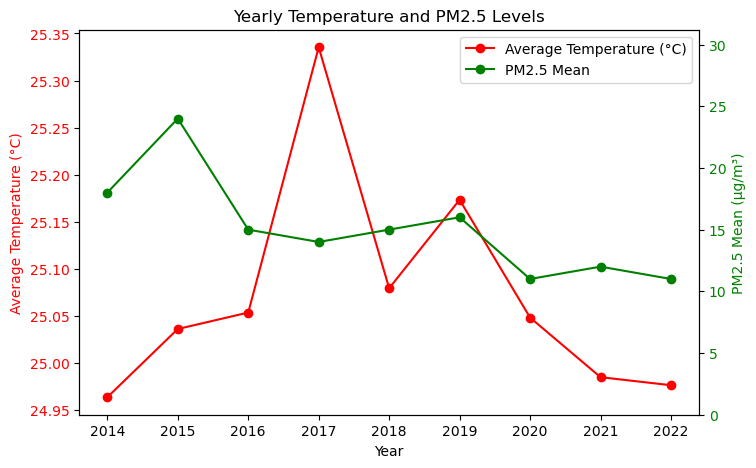

In [12]:
pm25 = np.array([record['pm25_mean'] for record in air_pollutant_particulate_matter])

# Plotting
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), gridspec_kw={'hspace': 0.5})

# Create a line plot for yearly average temperatures
ax1.plot(years, list(yearly_avg_temperatures.values()), color='red', marker='o', linestyle='-', label='Average Temperature (°C)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Temperature (°C)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a twin axis for PM2.5 levels
ax1b = ax1.twinx()
ax1b.plot(years, pm25, color='green', marker='o', linestyle='-', label='PM2.5 Mean')
ax1b.set_ylabel('PM2.5 Mean (µg/m³)', color='green')
ax1b.tick_params(axis='y', labelcolor='green')
ax1b.set_ylim(0, max(pm25) * 1.3)

ax1.set_title('Yearly Temperature and PM2.5 Levels')
handles1, labels1 = ax1.get_legend_handles_labels()
handles1b, labels1b = ax1b.get_legend_handles_labels()
ax1.legend(handles1 + handles1b, labels1 + labels1b, loc='upper right')


plt.show()

### Analyse for Yearly Temperature and PM2.5 Levels from Year 2014 to 2022
1. **Overall Pattern:** Based on the data, there appears to be a general positive correlation between temperature and PM2.5 levels, meaning that higher temperatures are generally associated with higher particulate matter concentrations. However, this relationship is not consistent throughout the entire period. For instance, from 2015 to 2016, temperature increased while PM2.5 levels decreased. Similarly, from 2016 to 2017, temperature increased while PM2.5 levels slightly decreased, and from 2017 to 2018, temperature dropped while PM2.5 levels slightly increased. These inconsistencies suggest that other factors may have influenced PM2.5 levels during these years. Generally, in the other years, an increase in temperature corresponds with an increase in PM2.5 levels, and a decrease in temperature corresponds with a decrease in PM2.5 levels.

2. **Yearly Trends:**
   - **2014 to 2015:** Both temperature and PM2.5 levels increased, indicating a clear positive correlation.
   - **2015 to 2016:** Temperature continued to increase while PM2.5 levels decreased, breaking the usual trend.
   - **2016 to 2017:** Temperature increased significantly, reaching a peak, while PM2.5 levels showed a slight decrease, breaking the usual trend.
   - **2017 to 2018:** Temperature dropped sharply, but PM2.5 levels increased slightly, again deviating from the general trend.
   - **2018 to 2020:** Both temperature and PM2.5 levels showed a decreasing trend, with PM2.5 levels decreasing sharply.
   - **2020 to 2022:** Temperature remained relatively low while PM2.5 levels continued to decrease, indicating improving air quality.

3. **Improvement in Air Quality:** From 2019 onwards, both temperature and PM2.5 levels showed a decreasing trend, with PM2.5 levels reaching their lowest and temperature at its second lowest, indicating an improvement in air quality over the years when the temperature decreased.

# Question 7: Do heavy rainfall events lead to improvements in air quality due to pollutant washout, as observed in yearly data?

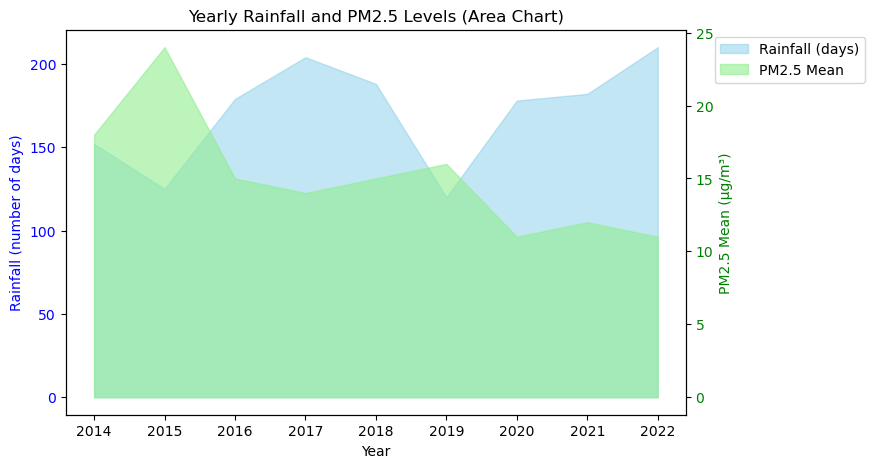

In [70]:
yearly_rainfall = []      # List to hold average yearly rainfall totals

# Fill in average temperatures and rainfall based on your data collection logic
for y in years:
    yearly_rain = [record['no_of_rainy_days'] for record in rainfall_monthly_number_of_rain_days if datetime.strptime(record['month'], '%Y-%m').year == y]
    yearly_rainfall.append(np.sum(yearly_rain) if yearly_rain else 0)  # Sum for total days of rainfall

# Plotting
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), gridspec_kw={'hspace': 0.5})

# Plot yearly rainfall as an area chart
ax1.fill_between(years, yearly_rainfall, color="skyblue", alpha=0.5, label='Rainfall (days)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Rainfall (number of days)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Overlay PM2.5 levels with a different y-axis
ax1b = ax1.twinx()
ax1b.fill_between(years, pm25, color="lightgreen", alpha=0.6, label='PM2.5 Mean')
ax1b.set_ylabel('PM2.5 Mean (µg/m³)', color='green')
ax1b.tick_params(axis='y', labelcolor='green')

ax1.set_title('Yearly Rainfall and PM2.5 Levels (Area Chart)')
handles1, labels1 = ax1.get_legend_handles_labels()
handles1b, labels1b = ax1b.get_legend_handles_labels()
ax1.legend(handles1 + handles1b, labels1 + labels1b, loc='upper right', bbox_to_anchor=(1.3,1.0))



### Analyse for Yearly Rainfall and PM2.5 Levels from year 2014-2022

1. **Inverse Relationship**: Generally, there seems to be an inverse relationship between rainfall and PM2.5 levels. In years where rainfall is higher, the PM2.5 levels tend to be lower, suggesting that rainfall may help in reducing PM2.5 levels.

2. **Specific Observations**:
   - **2014 - 2015**: When the number of rainfall days dropped from 150 to around 125 days, the PM2.5 increase from around 17µg/m³ to around 24µg/m³
   - **2015 - 2017**: Rainfall days increase, and there is an observable decrease in PM2.5 levels.
   - **2019**: There is a drop in rainfall, with a corresponding slight increase in PM2.5 levels.
   - **2019 - 2022**: A significant increase in rainfall days again correlates with a reduction in PM2.5 levels.

3. **Trends**: The overall trend suggests that during years with higher rainfall, there is a reduction in PM2.5 levels. This supports the hypothesis that heavy rainfall events can lead to improvements in air quality by washing out pollutants from the atmosphere.

**Conclusion**:
The data presented in the area chart supports the idea that heavy rainfall events can improve air quality by reducing PM2.5 levels. The observed inverse relationship between rainfall and PM2.5 levels suggests that rainfall contributes to the washout of pollutants, leading to better air quality in years with more rainfall.

# Question 8: How do air quality indices, particularly PSI, respond to rainfall and temperature change, is there any trend over the months throughout the years?

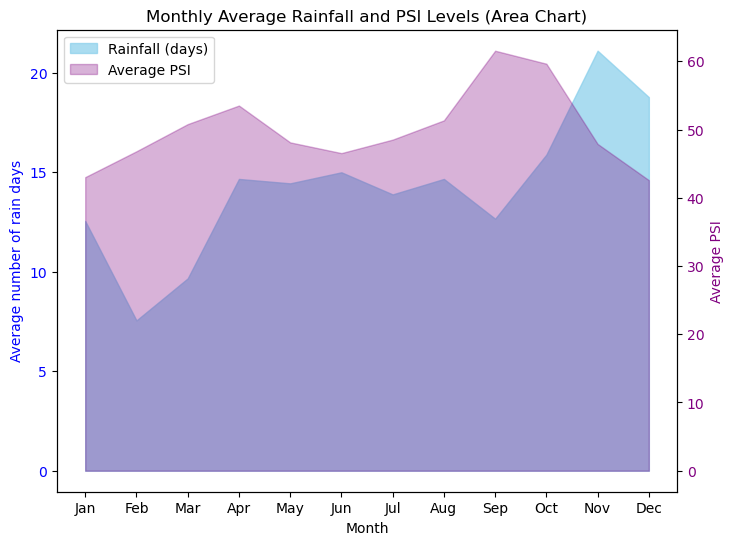

In [75]:
# Initialize arrays to store monthly averages
monthly_avg_psi = np.zeros(12)

# Populate monthly averages
for i in range(1, 13):    
    # Create masks for rainfall and PSI data
    month_mask_psi = np.array([datetime.strptime(date, '%Y-%m-%d').month == i for date in historical_psi['24hr_psi']])
    
    # Filter the daily average PSI for the current month
    month_avg_daily_psi = daily_avg_psi[month_mask_psi]
    
    # Store the monthly average PSI
    if month_avg_daily_psi.size > 0:
        monthly_avg_psi[i-1] = np.mean(month_avg_daily_psi)
    else:
        monthly_avg_psi[i-1] = np.nan  # Handle possible missing data

# Plotting the monthly average PSI and number of rainy days
fig, ax1 = plt.subplots(figsize=(8, 6))

# Area chart for Rainfall
ax1.fill_between(month_labels, monthly_avg_no_of_rain_days, color="skyblue", alpha=0.7, label='Rainfall (days)')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average number of rain days', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Overlay PSI levels with a different y-axis
ax1b = ax1.twinx()
ax1b.fill_between(month_labels, monthly_avg_psi, color="purple", alpha=0.3, label='Average PSI')
ax1b.set_ylabel('Average PSI', color='purple')
ax1b.tick_params(axis='y', labelcolor='purple')

ax1.set_title('Monthly Average Rainfall and PSI Levels (Area Chart)')
handles1, labels1 = ax1.get_legend_handles_labels()
handles1b, labels1b = ax1b.get_legend_handles_labels()
ax1.legend(handles1 + handles1b, labels1 + labels1b, loc='upper left')

plt.show()

### Analyse for Monthly Average Rainfall Count and PSI Levels over the Years (2014-2022)

1. **Inverse Relationship:** Generally, there is an inverse relationship between rainfall and PSI levels. In months with higher rainfall, PSI levels tend to be lower, suggesting that rainfall can help in reducing PSI levels. There are some anomalies; for example, from November to December, the number of rainy days decreases, but PSI also decreases. This can be explained by the fact that rainfall during these months is still relatively high (second highest overall), leading to the lowest PSI levels. Similarly, from January to April, despite having increase and decrease days of rainfall, it remains relatively low compared to other months, so, reasonable to still have the PSI to increase slightly.

2. **Specific Observations:**
   - **April to June:** An increase in rainfall days corresponds with a decrease in PSI levels.
   - **June to September:** There is a decrease in the average rainfall days per month, and the PSI levels increase correspondingly.
   - **September to November:** Increased average rainfall count per month correlates with a significant drop in PSI levels.

3. **Trends:** Throughout the months, a clear pattern is shown where higher rainfall correlates with lower PSI levels. This supports the hypothesis that rainfall contributes to the reduction of pollutants, leading to improved air quality.

**Conclusion:**  
The monthly data supports the idea that higher rainfall is associated with lower PSI levels, indicating improved air quality. This trend is generally consistent over the months, reinforcing the role of rainfall in pollutant washout.


## Conclusion Of All Analysis for topic : Assessing the Influence of Temperature and Rainfall on Air Quality


Based on the analyses conducted for various questions, several key insights emerge regarding the relationship between temperature, rainfall, and air quality (as measured by PSI and PM2.5 levels) over the study period from 2014 to 2022.

1. **PSI Distribution and Air Quality Levels:**
   - Daily PSI values are generally low, with most days having good to moderate air quality. However, occasional peaks indicate periods of poorer air quality, highlighting the need to understand environmental influences on these spikes.
   - The majority of days fall within the "Good" and "Moderate" air quality categories, but a notable percentage of days fall within the "Unhealthy" and "Very Unhealthy" categories, emphasizing the importance of investigating contributing factors.

2. **Temperature and Rainfall Trends:**
   - Rainfall shows distinct seasonal patterns, with peaks in November and December and lows in February and March. Temperature patterns are highest in May and lowest in February.
   - There is a general inverse relationship between temperature and rainfall, with higher temperatures corresponding to lower rainfall and vice versa.

3. **Impact on Air Quality Indicators:**
   - Annual air quality trends show notable peaks in PSI and PM2.5 levels in 2014 and 2015, with a subsequent improvement in air quality. The data suggest a positive correlation between PSI and PM2.5 levels.
   - Inconsistencies between 2015 and 2018 indicate other factors influencing PM2.5 levels, aside from temperature.

4. **Temperature and PSI Relationship:**
   - Higher temperatures are generally associated with higher PSI values, although the correlation is not strong. The most polluted conditions tend to occur at moderate temperatures (24°C to 27°C).

5. **Rainfall and PSI Relationship:**
   - Higher rainfall counts correspond to lower PSI values, supporting the hypothesis that rainfall helps reduce pollutant levels. A weak but noticeable pattern indicates that increased rainfall leads to improved air quality.

6. **Yearly Rainfall and PM2.5 Levels:**
   - An inverse relationship is evident, with years of higher rainfall showing lower PM2.5 levels, reinforcing the idea that heavy rainfall events contribute to the washout of pollutants.

7. **Monthly Rainfall and PSI Levels:**
   - Throughout the months, higher rainfall correlates with lower PSI levels, suggesting that rainfall significantly contributes to pollutant washout and improved air quality.

**Conclusion:**
The analyses collectively support the conclusion that both temperature and rainfall significantly influence air quality in Singapore. Higher temperatures are generally associated with poorer air quality (higher PSI and PM2.5 levels), while increased rainfall is associated with improved air quality. Understanding these relationships is crucial for developing effective strategies to manage air pollution and safeguard public health and environmental well-being. With this, if there is a possiblity of having lower rainfall and higher temperature in the futher month/year we need to be alert that there will be a high risk of poor air quality.